In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Reading files for clustering

In [2]:
NY_df = pd.read_csv('data/newyork_dataset', sep=',',low_memory=False, header=0, encoding='utf8')
CHI_df = pd.read_csv('data/chicago_dataset', sep=',',low_memory=False, header=0, encoding='utf8')
BOS_df = pd.read_csv('data/boston_dataset', sep=',',low_memory=False, header=0, encoding='utf8')

Reading files for visualization of results

In [3]:
NY_stations = pd.read_csv('data/newyork_stations_scores', sep=',',low_memory=False, header=0, encoding='utf8')
CHI_stations = pd.read_csv('data/chicago_stations_scores', sep=',',low_memory=False, header=0, encoding='utf8')
BOS_stations = pd.read_csv('data/boston_stations_scores', sep=',',low_memory=False, header=0, encoding='utf8')

Here the aim is to find some correlations between the stations of each of the three datasets, first separately then jointly, throught clustering technique based on Machine Learning.

In this case the algorithm chosen is the K-Means clustering provided by scikitlearn library.

### Importing necessary libraries

In [4]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

## Dataset preprocessing

The idea here is to give in input to the algorithm a matrix, where each column represents the vector of a station with the index i corresponding to an hour of the day and the value v[i] to the bike flow in the station in that hour.

This flow is positive if the number of incoming bikes is greater than the number of outgoing ones, negative flow otherwise.

### Input Matrix

In [5]:
def matrix_creation(df):
    
    in_df = df[['end station name', 'start hour', 'tripduration']].groupby(['end station name', 'start hour']).count()
    out_df = df[['start station name', 'start hour', 'tripduration']].groupby(['start station name', 'start hour']).count()
    in_df = in_df.reset_index()
    out_df = out_df.reset_index()
    t_df = pd.merge(left=out_df, right=in_df, how='outer', left_on=['start station name', 'start hour'],
                    right_on=['end station name', 'start hour'])
    t_df['tripduration_x'] = t_df['tripduration_x'].fillna(0)
    t_df['tripduration_y'] = t_df['tripduration_y'].fillna(0)
    t_df['flow'] = t_df['tripduration_y'] - t_df['tripduration_x']
    
    t_df.loc[t_df['end station name'].isnull(), 'end station name'] = t_df.loc[t_df['end station name'].isnull(),
                                                                               'start station name']
    t_df = t_df[['end station name', 'start hour', 'flow', 'tripduration_y', 'tripduration_x']]
    t_df.columns = ['station', 'start hour', 'flow', 'in_flow', 'out_flow']
    
    temp = pd.DataFrame(columns = t_df['start hour'].drop_duplicates())
    temp['station'] = t_df['station'].drop_duplicates()
    
    for row in t_df.iterrows():
        temp.loc[temp['station'] == row[1]['station'], row[1]['start hour']] = row[1]['flow']
    
    temp = temp.reset_index()
    temp = temp.fillna(0.0)
    
    return temp[range(24)], temp['station']
    # return temp[['station'] + (list(range(0,24)))].T
    
NY_matrix, NY_st_positions = matrix_creation(NY_df)
CHI_matrix, CHI_st_positions = matrix_creation(CHI_df)
BOS_matrix, BOS_st_positions = matrix_creation(BOS_df)

display(NY_matrix)
display(CHI_matrix)
display(BOS_matrix)

start hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,8.0,7.0,8.0,1.0,-7.0,-6.0,-12.0,-37.0,-77.0,-29.0,...,-22.0,1.0,12.0,34.0,5.0,46.0,7.0,29.0,22.0,9.0
1,14.0,13.0,10.0,-2.0,-2.0,-23.0,-184.0,-232.0,-546.0,-276.0,...,15.0,35.0,50.0,359.0,310.0,223.0,159.0,84.0,110.0,16.0
2,10.0,13.0,7.0,-11.0,-2.0,-49.0,-143.0,-316.0,-412.0,-113.0,...,15.0,35.0,70.0,263.0,377.0,127.0,22.0,22.0,33.0,13.0
3,-1.0,0.0,-2.0,21.0,17.0,40.0,316.0,154.0,3.0,0.0,...,-58.0,-123.0,-161.0,-15.0,12.0,31.0,-43.0,8.0,0.0,5.0
4,-3.0,1.0,5.0,-3.0,3.0,25.0,0.0,184.0,612.0,217.0,...,-14.0,-31.0,-189.0,-546.0,-122.0,-48.0,-8.0,15.0,9.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,2.0,...,3.0,5.0,7.0,4.0,8.0,5.0,5.0,3.0,5.0,2.0
788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


start hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,8.0,0.0,10.0,0.0,0.0,0.0,-1.0,...,-2.0,1.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,-2.0,...,3.0,4.0,3.0,-1.0,-3.0,-11.0,-3.0,0.0,0.0,1.0
2,-1.0,1.0,0.0,1.0,0.0,-4.0,13.0,33.0,48.0,5.0,...,-1.0,-36.0,-50.0,-27.0,-22.0,2.0,-28.0,-3.0,-1.0,1.0
3,0.0,1.0,0.0,0.0,-1.0,-28.0,-16.0,-21.0,-43.0,11.0,...,-7.0,-17.0,69.0,36.0,9.0,22.0,8.0,1.0,0.0,2.0
4,2.0,0.0,-1.0,2.0,-1.0,-12.0,-47.0,-39.0,-34.0,-20.0,...,13.0,28.0,60.0,39.0,14.0,4.0,-8.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,0.0,2.0,-1.0,0.0,0.0,1.0,-2.0,-5.0,17.0,-2.0,...,4.0,-9.0,-9.0,24.0,3.0,1.0,-4.0,-12.0,-2.0,-1.0
569,0.0,0.0,0.0,0.0,0.0,-2.0,-7.0,-5.0,-21.0,0.0,...,-3.0,-1.0,3.0,20.0,5.0,1.0,4.0,3.0,0.0,0.0
570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


start hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-1.0,1.0,2.0,-3.0,0.0,1.0,10.0,-16.0,-38.0,1.0,...,3.0,1.0,33.0,15.0,19.0,-8.0,7.0,4.0,3.0,3.0
1,0.0,2.0,3.0,2.0,2.0,0.0,0.0,3.0,22.0,3.0,...,4.0,4.0,-16.0,-1.0,6.0,3.0,1.0,1.0,1.0,1.0
2,-1.0,1.0,0.0,3.0,0.0,-3.0,-5.0,-27.0,-76.0,-30.0,...,0.0,12.0,25.0,46.0,31.0,19.0,34.0,16.0,11.0,5.0
3,-1.0,-6.0,1.0,0.0,-2.0,0.0,7.0,-19.0,-18.0,-35.0,...,-6.0,11.0,16.0,31.0,37.0,12.0,-7.0,-10.0,-10.0,2.0
4,9.0,1.0,1.0,2.0,1.0,-21.0,-19.0,-72.0,-172.0,-106.0,...,-7.0,16.0,34.0,31.0,76.0,62.0,39.0,22.0,21.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,-1.0,-3.0,-5.0,0.0,0.0,11.0,41.0,144.0,93.0,23.0,...,17.0,-29.0,-94.0,-120.0,-36.0,1.0,-4.0,-6.0,2.0,-1.0
264,-6.0,-5.0,0.0,1.0,1.0,-1.0,-2.0,4.0,6.0,38.0,...,12.0,-22.0,-19.0,-22.0,5.0,6.0,-19.0,-5.0,-2.0,5.0
265,-2.0,3.0,0.0,0.0,0.0,1.0,-1.0,-88.0,-324.0,-119.0,...,7.0,19.0,161.0,232.0,30.0,27.0,25.0,-5.0,4.0,3.0
266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,-13.0,-7.0,...,4.0,-1.0,11.0,5.0,12.0,16.0,1.0,0.0,3.0,1.0


### Correlation Matrix

(Just for fun)

In [6]:
NY_matrix.corr()

start hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
start hour,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.514547,0.408949,0.229108,-0.078040,-0.111190,-0.201074,-0.269240,-0.339245,-0.381617,...,0.014425,0.098761,0.128130,0.167947,0.279255,0.409495,0.489290,0.575273,0.604603,0.616286
1,0.514547,1.000000,0.412702,0.275750,0.011117,-0.117865,-0.193297,-0.221873,-0.247092,-0.227509,...,0.021151,0.051332,0.058840,0.073359,0.176654,0.294610,0.420640,0.517887,0.524635,0.515846
2,0.408949,0.412702,1.000000,0.162905,-0.060444,-0.117690,-0.125920,-0.213677,-0.261578,-0.234095,...,0.079624,0.066184,0.082349,0.139379,0.217106,0.245338,0.300633,0.367018,0.368522,0.383211
3,0.229108,0.275750,0.162905,1.000000,0.081201,-0.011345,-0.010500,-0.030068,-0.035012,-0.046352,...,-0.052349,-0.051083,-0.044445,-0.040583,0.013637,0.082530,0.125599,0.201206,0.168888,0.213129
4,-0.078040,0.011117,-0.060444,0.081201,1.000000,0.501187,0.422540,0.366112,0.297749,0.245488,...,-0.396931,-0.483318,-0.453259,-0.353530,-0.211659,-0.164416,-0.174355,-0.096892,-0.047469,-0.093907
5,-0.111190,-0.117865,-0.117690,-0.011345,0.501187,1.000000,0.632233,0.499942,0.394050,0.325815,...,-0.542104,-0.590491,-0.541467,-0.438559,-0.307796,-0.274042,-0.316750,-0.189506,-0.146759,-0.183705
6,-0.201074,-0.193297,-0.125920,-0.010500,0.422540,0.632233,1.000000,0.795220,0.546339,0.383652,...,-0.462208,-0.622223,-0.773560,-0.674617,-0.443970,-0.341373,-0.361722,-0.250319,-0.209013,-0.236086
7,-0.269240,-0.221873,-0.213677,-0.030068,0.366112,0.499942,0.795220,1.000000,0.807582,0.548558,...,-0.405213,-0.549611,-0.740788,-0.813241,-0.677203,-0.513259,-0.495171,-0.389768,-0.321884,-0.308600
8,-0.339245,-0.247092,-0.261578,-0.035012,0.297749,0.394050,0.546339,0.807582,1.000000,0.818406,...,-0.334972,-0.466937,-0.629775,-0.856691,-0.857828,-0.703386,-0.600752,-0.495705,-0.430546,-0.364791


<AxesSubplot:xlabel='start hour', ylabel='start hour'>

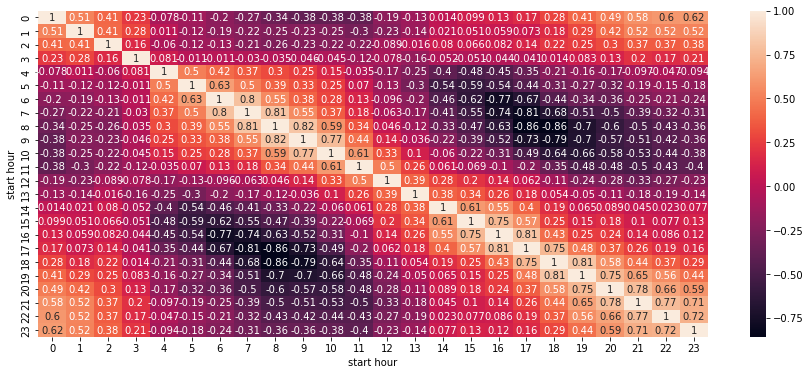

In [7]:
plt.figure(figsize = (15,6))
sns.heatmap(NY_matrix.corr(), annot=True)

### Normalization or Scaling ?

Since the aim is to find clusters which group stations having a similar trend in the daily flow, normalization is required so that they are put in the same cluster althought they might have different amount of traffic.

It can be add another analysis considering also the amount of traffic.

In [8]:
# Normalization
NY_norm = MinMaxScaler().fit_transform(NY_matrix)
CHI_norm = MinMaxScaler().fit_transform(CHI_matrix)
BOS_norm = MinMaxScaler().fit_transform(BOS_matrix)

In [9]:
# Scaling
NY_scal = StandardScaler().fit_transform(NY_matrix)
CHI_scal = StandardScaler().fit_transform(CHI_matrix)
BOS_scal = StandardScaler().fit_transform(BOS_matrix)

These are the values before normalization

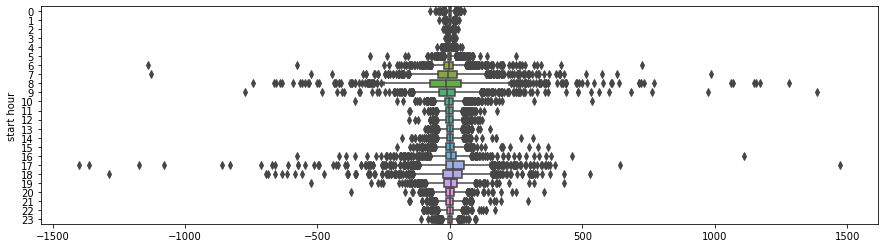

In [10]:
plt.figure(figsize = (15,4))
sns.boxplot(data = NY_matrix, orient = "h")
plt.show()

These are the values after normalization

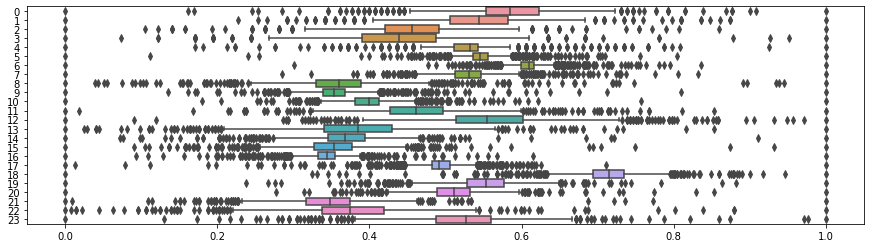

In [11]:
plt.figure(figsize = (15,4))
sns.boxplot(data = NY_norm, orient = "h")
plt.show()

These are the values after scaling

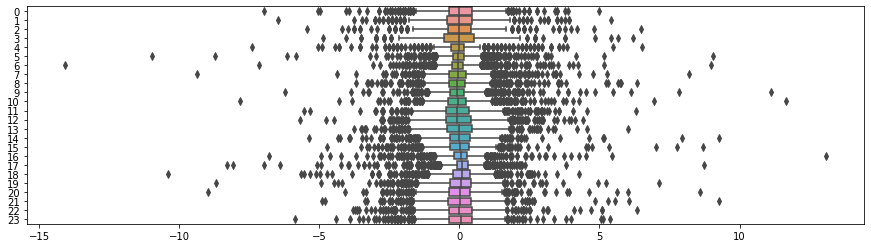

In [12]:
plt.figure(figsize = (15,4))
sns.boxplot(data = NY_scal, orient = "h")
plt.show()

## Choosing number of clusters k

C:\Users\tomma\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


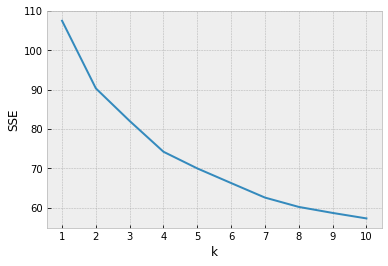

C:\Users\tomma\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


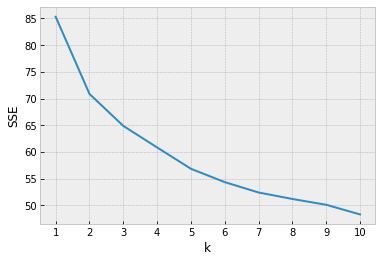

C:\Users\tomma\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


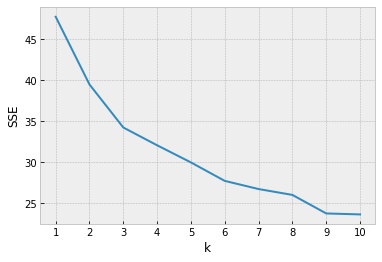

4 3 3


In [13]:
def num_clusters(data):
    params = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42} # try a different set of parameters
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **params)  # Python’s dictionary unpacking operator (**)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    plt.style.use("bmh")
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.show()

    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    return kl.elbow  # KneeLocator number of clusters
    
NY_k = num_clusters(NY_norm)
CHI_k = num_clusters(CHI_norm)
BOS_k = num_clusters(BOS_norm)

print(NY_k, CHI_k, BOS_k)

## K-Means algorithm

In [14]:
def clustering_kmeans(df, pos, data, k):
    kmeans = KMeans(n_clusters = k).fit(data)
    display(kmeans.cluster_centers_)
    display(kmeans.labels_)
    pos['cluster'] = kmeans.labels_
    # return pd.merge(left=df, right=pos, how='left', left_on='Nodes', right_on='station'), data
    return pd.merge(left=df, right=pos, how='left', left_on='Nodes', right_on='station'), kmeans.labels_
    
NY_stations, NY_labels = clustering_kmeans(NY_stations, pd.DataFrame(NY_st_positions), NY_norm, NY_k)
CHI_stations, CHI_labels = clustering_kmeans(CHI_stations, pd.DataFrame(CHI_st_positions), CHI_norm, CHI_k)
BOS_stations, BOS_labels = clustering_kmeans(BOS_stations, pd.DataFrame(BOS_st_positions), BOS_norm, BOS_k)

array([[0.59189587, 0.54522352, 0.45483211, 0.43883785, 0.52870103,
        0.54442715, 0.60785099, 0.52768304, 0.35833495, 0.35455085,
        0.398543  , 0.46367689, 0.55958517, 0.38752625, 0.37036522,
        0.35675562, 0.3447852 , 0.49264541, 0.71435784, 0.55300371,
        0.51239945, 0.34796674, 0.37788916, 0.5255817 ],
       [0.65975275, 0.62805154, 0.52788221, 0.47952962, 0.51234802,
        0.52225626, 0.57795606, 0.47987374, 0.25763291, 0.30642774,
        0.3577514 , 0.39479346, 0.51960404, 0.37456089, 0.39128788,
        0.38786903, 0.37156308, 0.53188731, 0.77211963, 0.61991399,
        0.57837302, 0.43427136, 0.50042673, 0.62154934],
       [0.55602755, 0.52862271, 0.41267347, 0.45249363, 0.60939981,
        0.60662926, 0.67128127, 0.63508063, 0.55178942, 0.43772803,
        0.43650463, 0.46277648, 0.4745836 , 0.25648397, 0.27369215,
        0.23828319, 0.25567005, 0.37835717, 0.61261498, 0.49639759,
        0.46843969, 0.31299973, 0.33708297, 0.48662485],
       [0.468

array([1, 1, 1, 2, 2, 0, 2, 1, 0, 1, 0, 0, 0, 3, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 3,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0, 0, 1, 0, 3, 1, 0, 3, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 3, 0, 0,
       2, 0, 3, 2, 0, 0, 0, 2, 2, 3, 0, 0, 2, 2, 2, 2, 0, 2, 3, 0, 0, 0,
       0, 0, 0, 3, 2, 0, 0, 0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 3, 3, 0, 3, 3, 0, 1, 1, 0, 1, 0, 0, 3, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 1, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0,

array([[0.54319053, 0.51532567, 0.4983165 , 0.49431818, 0.43522178,
        0.47460492, 0.58007015, 0.58750029, 0.37550315, 0.30176393,
        0.22590909, 0.19928603, 0.33958148, 0.41352201, 0.35544332,
        0.36661607, 0.36812479, 0.76613822, 0.69373972, 0.72240928,
        0.52234106, 0.5228794 , 0.51262626, 0.54349747],
       [0.44022989, 0.4545977 , 0.45416667, 0.496875  , 0.46231884,
        0.57822581, 0.65679949, 0.70350269, 0.51437522, 0.42908012,
        0.296     , 0.22038369, 0.34460784, 0.40496855, 0.31524691,
        0.30500928, 0.29495998, 0.63573347, 0.55300388, 0.60802469,
        0.37960784, 0.42088353, 0.37901235, 0.44      ],
       [0.63778367, 0.55585028, 0.52920228, 0.52083333, 0.41917503,
        0.42735043, 0.56212394, 0.55190383, 0.32746702, 0.2554465 ,
        0.18551282, 0.18139335, 0.33041101, 0.40712788, 0.35846787,
        0.37453023, 0.37932966, 0.81439306, 0.75670841, 0.79310813,
        0.63016591, 0.61064772, 0.61000317, 0.6284188 ]])

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2,
       2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 1, 0,
       0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2,
       0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0,
       2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 2, 0, 2, 1, 0, 2, 0, 0,

array([[0.66836789, 0.56295951, 0.55388471, 0.5307177 , 0.64217362,
        0.49075391, 0.51115154, 0.59504895, 0.28697135, 0.14862354,
        0.15450887, 0.19816016, 0.25815322, 0.28453465, 0.45354326,
        0.33492823, 0.30233229, 0.44082179, 0.76065587, 0.79501165,
        0.79163331, 0.72894619, 0.70617303, 0.70357356],
       [0.59259259, 0.55284553, 0.3968254 , 0.54666667, 0.6547619 ,
        0.58558559, 0.69968051, 0.83997873, 0.72094508, 0.49057207,
        0.47976012, 0.48997135, 0.52298851, 0.34408602, 0.27927928,
        0.1091954 , 0.10514726, 0.15149272, 0.31852913, 0.16909621,
        0.29961089, 0.26600985, 0.15846995, 0.47395833],
       [0.55793651, 0.43728223, 0.41836735, 0.47857143, 0.64477041,
        0.59459459, 0.57764719, 0.68042265, 0.37558155, 0.18529996,
        0.18689762, 0.2489255 , 0.301211  , 0.34763825, 0.42652027,
        0.29538177, 0.26893358, 0.38706778, 0.70249181, 0.72126197,
        0.71650917, 0.66001056, 0.6118267 , 0.56417411]])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0, 0,
       0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0])

## Visualization of the results

In [15]:
NY_matrix

start hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,8.0,7.0,8.0,1.0,-7.0,-6.0,-12.0,-37.0,-77.0,-29.0,...,-22.0,1.0,12.0,34.0,5.0,46.0,7.0,29.0,22.0,9.0
1,14.0,13.0,10.0,-2.0,-2.0,-23.0,-184.0,-232.0,-546.0,-276.0,...,15.0,35.0,50.0,359.0,310.0,223.0,159.0,84.0,110.0,16.0
2,10.0,13.0,7.0,-11.0,-2.0,-49.0,-143.0,-316.0,-412.0,-113.0,...,15.0,35.0,70.0,263.0,377.0,127.0,22.0,22.0,33.0,13.0
3,-1.0,0.0,-2.0,21.0,17.0,40.0,316.0,154.0,3.0,0.0,...,-58.0,-123.0,-161.0,-15.0,12.0,31.0,-43.0,8.0,0.0,5.0
4,-3.0,1.0,5.0,-3.0,3.0,25.0,0.0,184.0,612.0,217.0,...,-14.0,-31.0,-189.0,-546.0,-122.0,-48.0,-8.0,15.0,9.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,2.0,...,3.0,5.0,7.0,4.0,8.0,5.0,5.0,3.0,5.0,2.0
788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


start hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,mean
5,-1.0,0.0,-4.0,2.0,-17.0,-26.0,2.0,-34.0,-81.0,-4.0,...,38.0,12.0,129.0,14.0,-28.0,-38.0,-20.0,-3.0,-6.0,0.625000
8,0.0,5.0,0.0,2.0,2.0,-5.0,-51.0,-43.0,-101.0,-59.0,...,17.0,59.0,95.0,48.0,43.0,13.0,8.0,11.0,6.0,0.458333
10,1.0,0.0,0.0,0.0,0.0,3.0,36.0,9.0,100.0,32.0,...,-7.0,-16.0,-83.0,-63.0,-13.0,-10.0,-3.0,-3.0,2.0,-0.083333
11,2.0,0.0,1.0,2.0,0.0,-2.0,-3.0,1.0,-7.0,5.0,...,18.0,-1.0,26.0,9.0,13.0,3.0,-8.0,8.0,-1.0,0.500000
12,6.0,-2.0,-4.0,-3.0,-2.0,8.0,-4.0,4.0,-57.0,-19.0,...,-27.0,1.0,39.0,-11.0,22.0,16.0,1.0,17.0,19.0,-2.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667
787,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,2.0,...,5.0,7.0,4.0,8.0,5.0,5.0,3.0,5.0,2.0,2.791667
788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667


start hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,mean
0,8.0,7.0,8.0,1.0,-7.0,-6.0,-12.0,-37.0,-77.0,-29.0,...,1.0,12.0,34.0,5.0,46.0,7.0,29.0,22.0,9.0,-0.208333
1,14.0,13.0,10.0,-2.0,-2.0,-23.0,-184.0,-232.0,-546.0,-276.0,...,35.0,50.0,359.0,310.0,223.0,159.0,84.0,110.0,16.0,-5.583333
2,10.0,13.0,7.0,-11.0,-2.0,-49.0,-143.0,-316.0,-412.0,-113.0,...,35.0,70.0,263.0,377.0,127.0,22.0,22.0,33.0,13.0,-4.125000
7,5.0,1.0,0.0,8.0,-6.0,-58.0,-77.0,-317.0,-420.0,-51.0,...,56.0,176.0,327.0,272.0,129.0,33.0,17.0,5.0,2.0,2.375000
9,7.0,4.0,3.0,3.0,-1.0,-5.0,-37.0,-64.0,-139.0,-63.0,...,-2.0,23.0,67.0,83.0,39.0,28.0,16.0,33.0,24.0,-1.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,-5.0,4.0,2.0,2.0,0.0,-11.0,-63.0,-146.0,-297.0,-36.0,...,-40.0,-46.0,77.0,51.0,-3.0,21.0,16.0,8.0,20.0,-24.833333
751,5.0,2.0,6.0,1.0,0.0,-3.0,-38.0,-80.0,-121.0,-46.0,...,-5.0,7.0,52.0,73.0,13.0,26.0,-19.0,21.0,7.0,-9.916667
759,-1.0,2.0,6.0,2.0,1.0,-2.0,-15.0,-113.0,-154.0,-49.0,...,-9.0,12.0,52.0,94.0,29.0,30.0,23.0,14.0,17.0,-5.708333
769,23.0,6.0,2.0,2.0,2.0,-13.0,-81.0,-116.0,-101.0,-63.0,...,85.0,24.0,37.0,34.0,47.0,81.0,45.0,36.0,22.0,2.541667


start hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,mean
3,-1.0,0.0,-2.0,21.0,17.0,40.0,316.0,154.0,3.0,0.0,...,-123.0,-161.0,-15.0,12.0,31.0,-43.0,8.0,0.0,5.0,0.333333
4,-3.0,1.0,5.0,-3.0,3.0,25.0,0.0,184.0,612.0,217.0,...,-31.0,-189.0,-546.0,-122.0,-48.0,-8.0,15.0,9.0,7.0,0.958333
6,10.0,0.0,8.0,-3.0,22.0,43.0,418.0,173.0,119.0,26.0,...,-105.0,-228.0,-160.0,-31.0,-60.0,6.0,-8.0,-8.0,32.0,0.958333
68,0.0,-4.0,-1.0,-4.0,14.0,24.0,85.0,68.0,164.0,60.0,...,-49.0,-6.0,-61.0,-77.0,-20.0,-9.0,-20.0,-8.0,-4.0,0.166667
105,-7.0,0.0,-12.0,2.0,3.0,76.0,72.0,110.0,477.0,329.0,...,-141.0,-216.0,-387.0,-71.0,-7.0,-18.0,-26.0,-10.0,-31.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,12.0,-14.0,5.0,0.0,9.0,37.0,81.0,241.0,289.0,9.0,...,-53.0,-177.0,-130.0,-42.0,-16.0,-17.0,3.0,-27.0,-8.0,1.541667
732,-7.0,-4.0,-6.0,0.0,19.0,67.0,240.0,575.0,1061.0,602.0,...,-110.0,-359.0,-1174.0,-686.0,-120.0,-46.0,-1.0,-4.0,-2.0,9.291667
733,-9.0,8.0,3.0,2.0,11.0,87.0,343.0,412.0,1070.0,684.0,...,-201.0,-576.0,-1364.0,-385.0,-58.0,-44.0,-45.0,-4.0,-8.0,5.666667
736,0.0,-9.0,-3.0,1.0,7.0,64.0,189.0,332.0,229.0,-7.0,...,-138.0,-189.0,-83.0,-58.0,-3.0,-1.0,-13.0,-25.0,4.0,0.208333


start hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,mean
13,-12.0,-4.0,-2.0,-3.0,-5.0,-3.0,284.0,167.0,578.0,484.0,...,-60.0,-240.0,-612.0,-615.0,-143.0,-33.0,-9.0,-21.0,16.0,4.208333
27,-22.0,-8.0,-12.0,-5.0,-5.0,24.0,-4.0,41.0,-81.0,-107.0,...,64.0,-15.0,100.0,60.0,-64.0,-42.0,-43.0,-3.0,-2.0,-2.000000
107,-3.0,1.0,1.0,1.0,0.0,6.0,42.0,75.0,74.0,-30.0,...,-62.0,-36.0,-76.0,-106.0,-168.0,-14.0,-12.0,-25.0,-8.0,0.166667
109,-10.0,-7.0,9.0,2.0,0.0,4.0,15.0,3.0,3.0,143.0,...,-93.0,-20.0,-132.0,-7.0,-125.0,-91.0,-20.0,-4.0,-4.0,1.083333
116,-14.0,-1.0,1.0,1.0,6.0,5.0,47.0,147.0,301.0,192.0,...,-65.0,-93.0,-251.0,-211.0,-50.0,-1.0,-3.0,-42.0,-3.0,3.458333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,-15.0,-12.0,-5.0,3.0,-4.0,-10.0,-19.0,-12.0,-33.0,-31.0,...,27.0,-11.0,57.0,37.0,22.0,0.0,-18.0,-23.0,-21.0,0.416667
761,-17.0,-5.0,-8.0,-2.0,17.0,22.0,23.0,191.0,173.0,218.0,...,-67.0,-88.0,-60.0,-84.0,-82.0,-93.0,-44.0,-26.0,-22.0,5.500000
762,-19.0,-2.0,-10.0,-6.0,-7.0,-16.0,-23.0,-85.0,82.0,8.0,...,66.0,-73.0,2.0,-55.0,-13.0,40.0,-67.0,-32.0,-53.0,2.541667
768,-5.0,-8.0,-1.0,3.0,-18.0,55.0,135.0,414.0,721.0,284.0,...,-29.0,1.0,-174.0,-355.0,-145.0,-143.0,-45.0,-10.0,7.0,37.833333


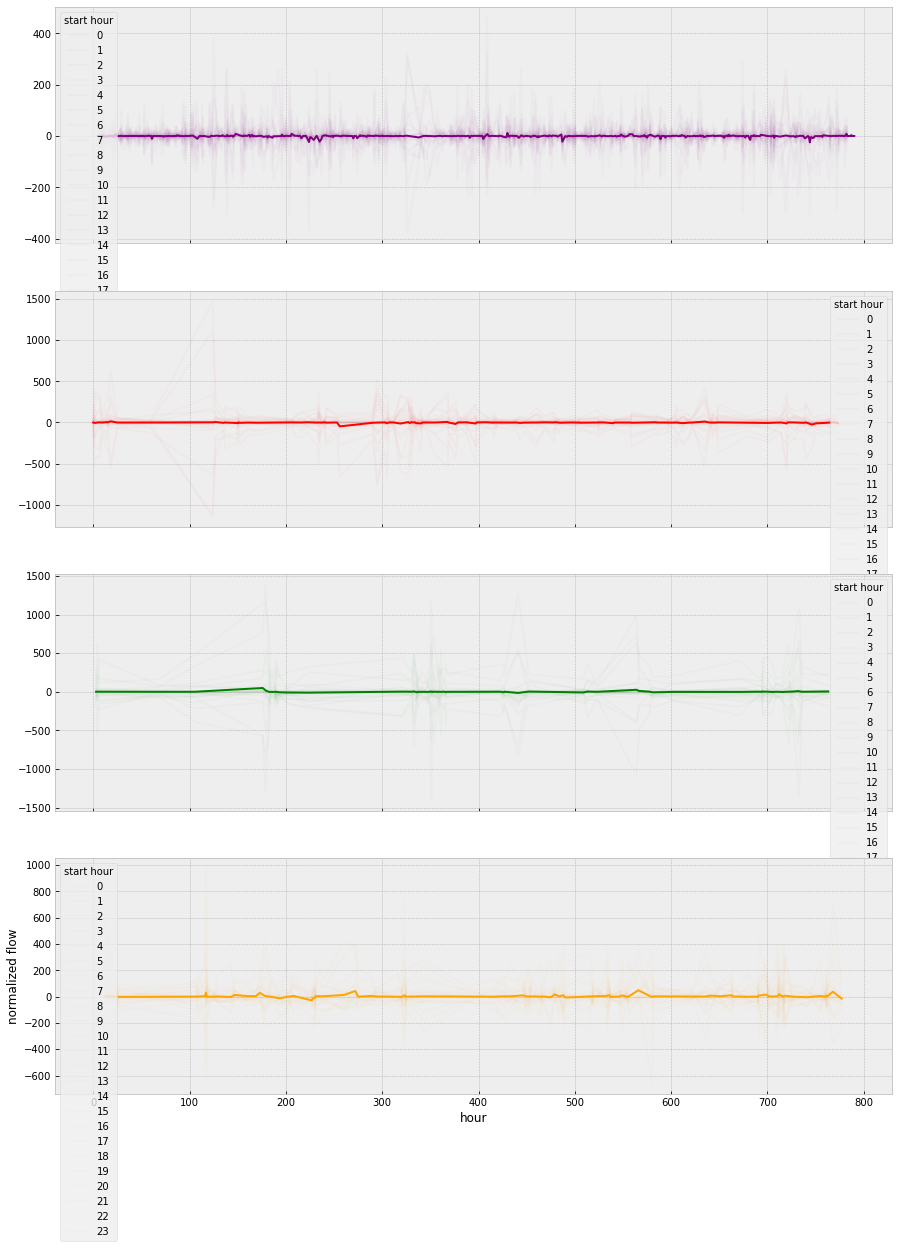

In [16]:
colors = ['purple', 'red', 'green', 'orange', 'blue']
hours = range(24)

def plots(df):
    n_clust = df['cluster'].max() + 1
    fig, axs = plt.subplots(n_clust,1, sharex=True, figsize = (15,20))
    for cl in range(n_clust):
        df_cl = df.loc[df['cluster'] == cl, range(24)]
        df_cl['mean'] = df_cl.mean(numeric_only=True, axis=1) # la fa per righe
        # df_cl.plot(ax=axs[cl], color=colors[cl], alpha=0.02)
        # axs[cl].plot(data=df_cl[range(24)], color=colors[cl], alpha=0.02)
        # df_cl = df_cl.T
        display(df_cl)
        df_cl[range(24)].plot(ax=axs[cl], color=colors[cl], alpha=0.02)
        # axs[cl].plot(range(24), df_cl[range(24)], color=colors[cl], alpha=0.02)
        df_cl['mean'].plot(ax=axs[cl], color=colors[cl], alpha=1)
        # axs[cl].get_legend().remove()
        plt.ylabel('normalized flow')
        plt.xlabel('hour')

NY_matrix['cluster'] = NY_labels # sistemare
plots(NY_matrix)

In [17]:
colors = ['purple', 'red', 'green', 'orange', 'blue']
hours = range(24)

def plots(df):
    n_clust = df['cluster'].max() + 1
    fig, axs = plt.subplots(n_clust,1, sharex=True, figsize = (20,40))
    for cl in range(n_clust):
        df_cl = df.loc[df['cluster'] == cl, range(24)]
        for row in df_cl.iterrows():
            axs[cl].plot(hours, row[1], color=colors[cl], alpha=0.02)
            
        mean = df_cl.T.mean(numeric_only=True, axis=1) # la fa per righe ?
        axs[cl].plot(hours, mean, color=colors[cl])
        # axs[cl].get_legend().remove()
        plt.ylabel('normalized flow')
        plt.xlabel('hour')
    axs[n_clust-1].set_xticks(hours)

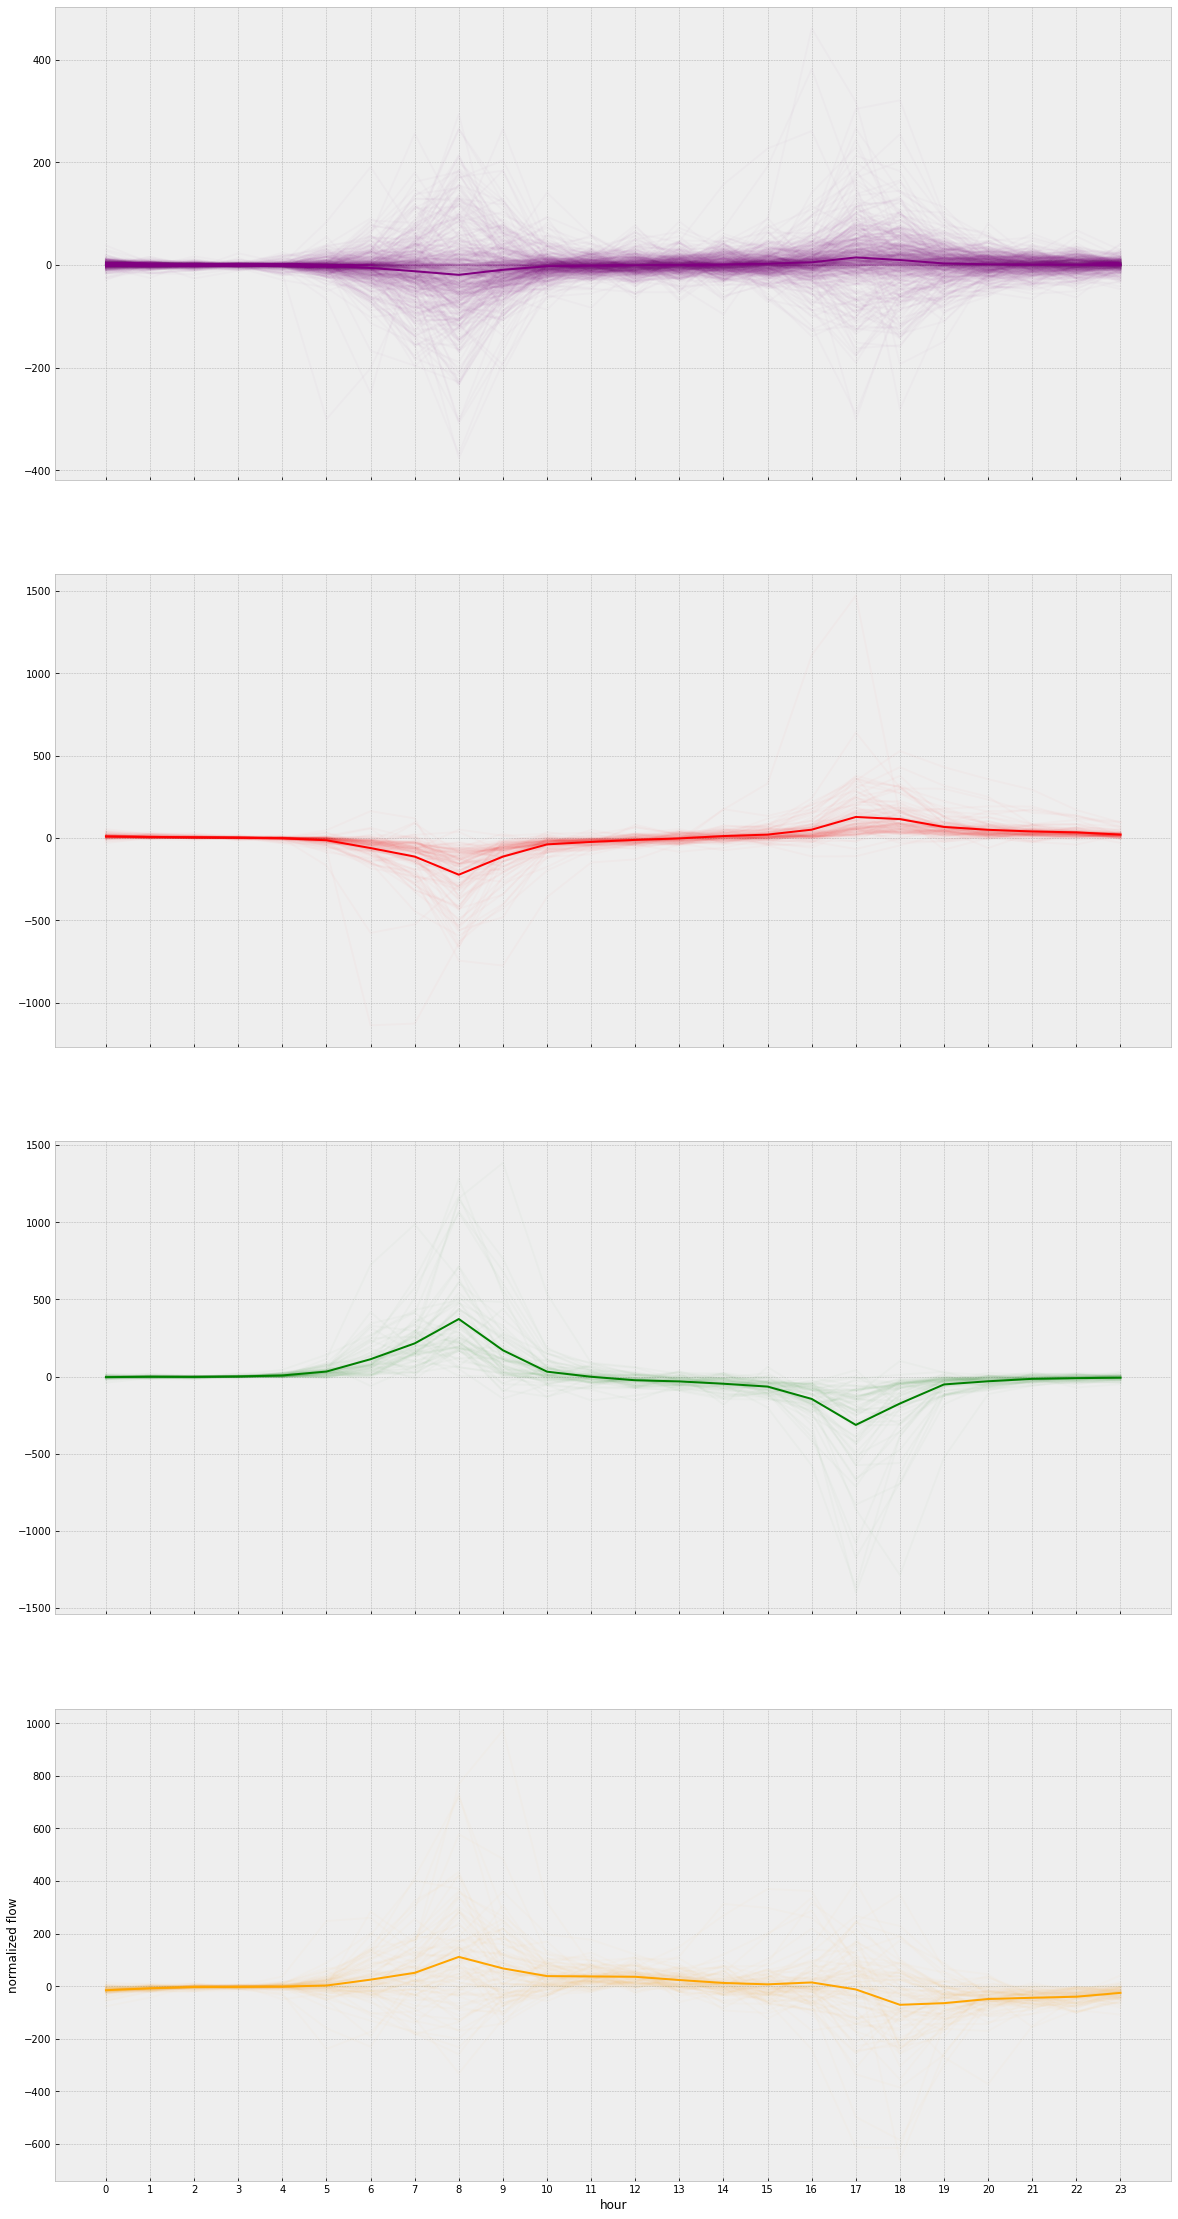

In [18]:
NY_matrix['cluster'] = NY_labels
plots(NY_matrix)

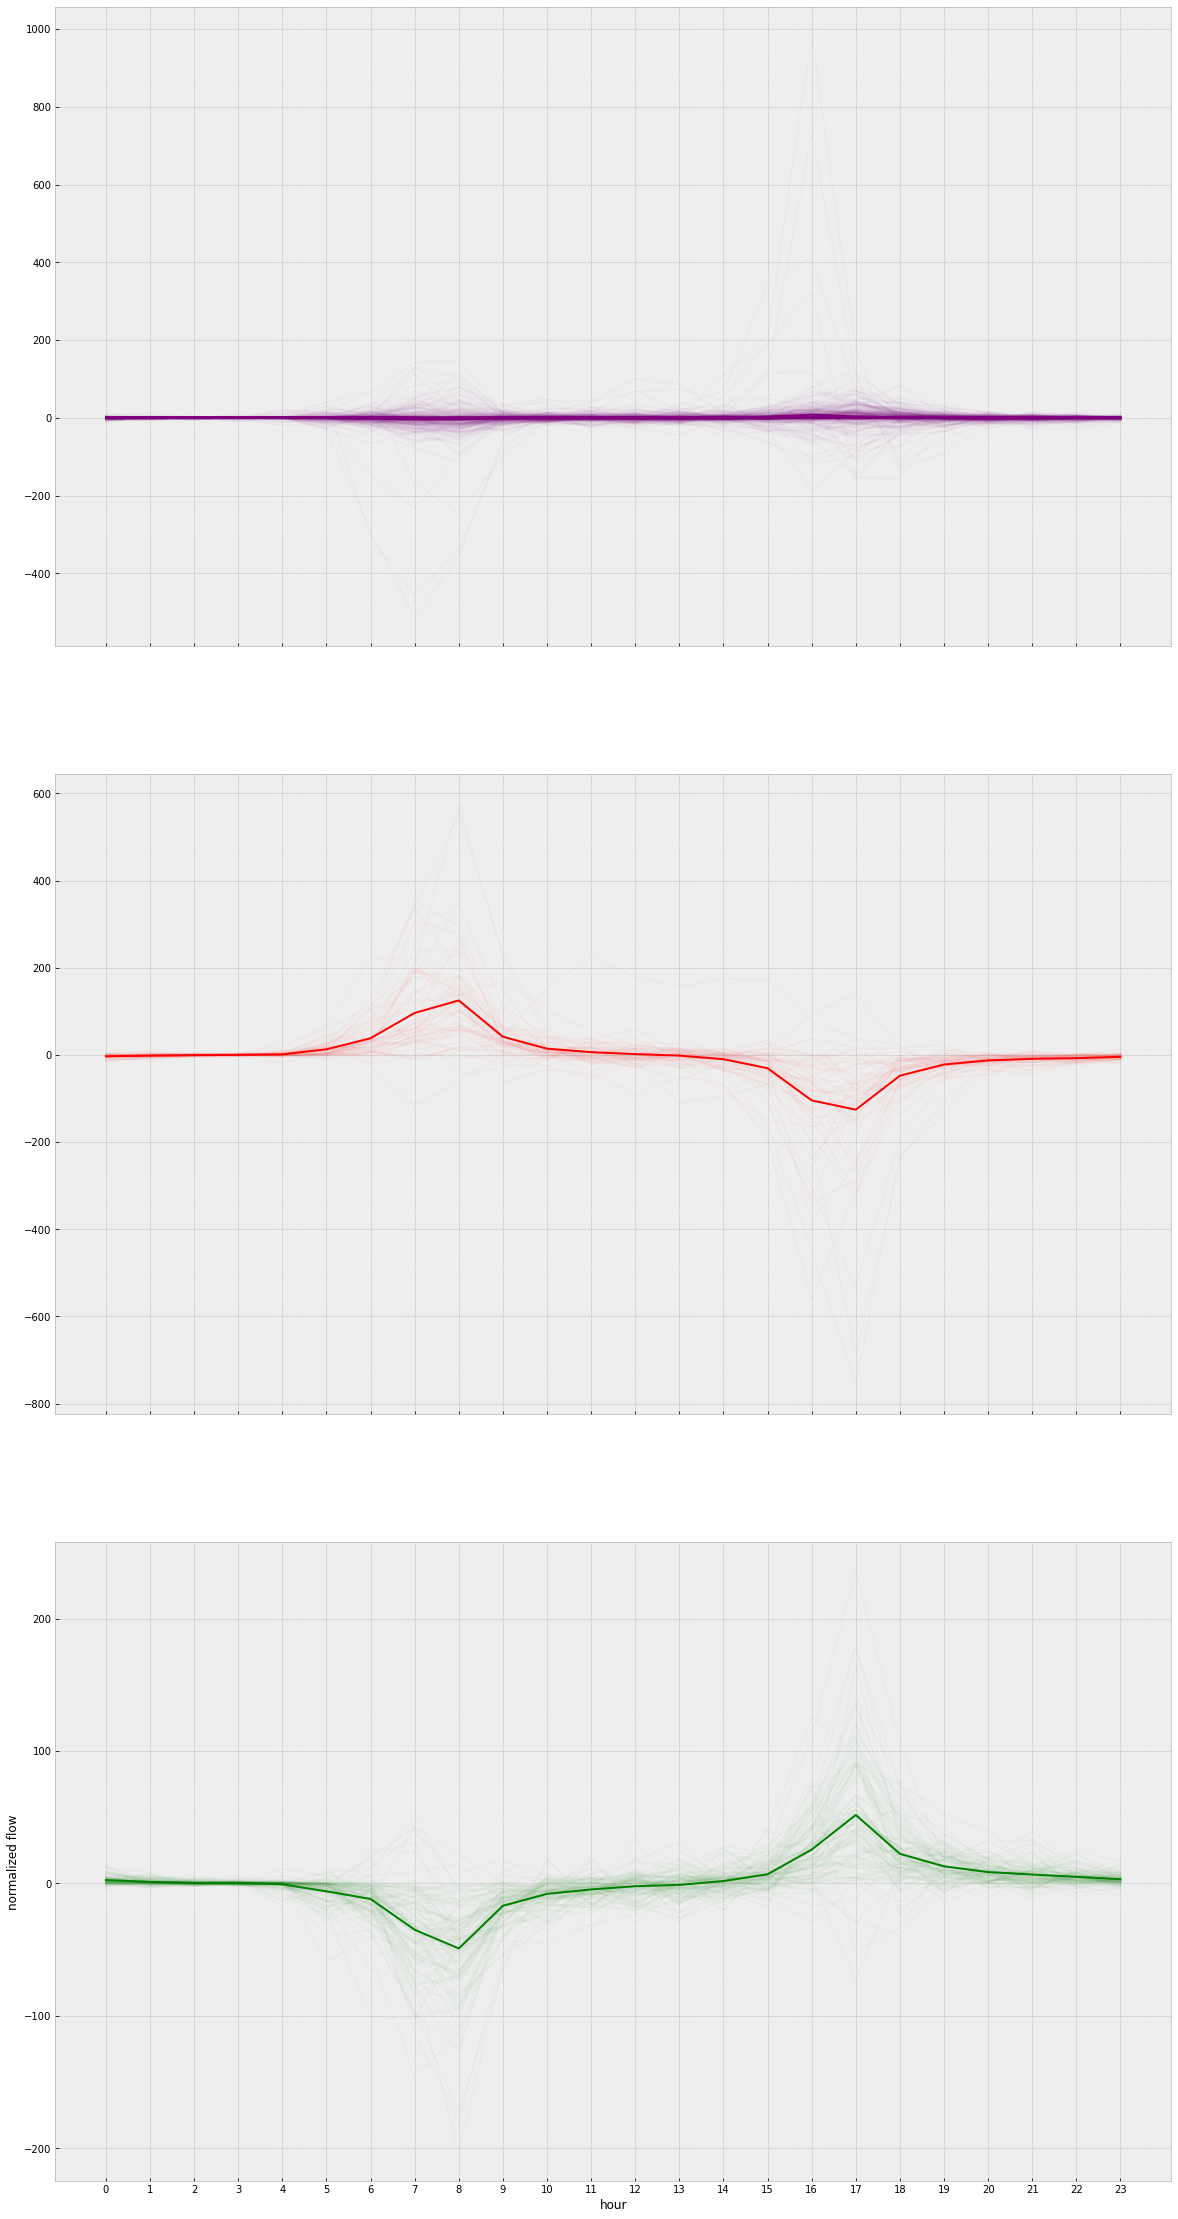

In [19]:
CHI_matrix['cluster'] = CHI_labels
plots(CHI_matrix)

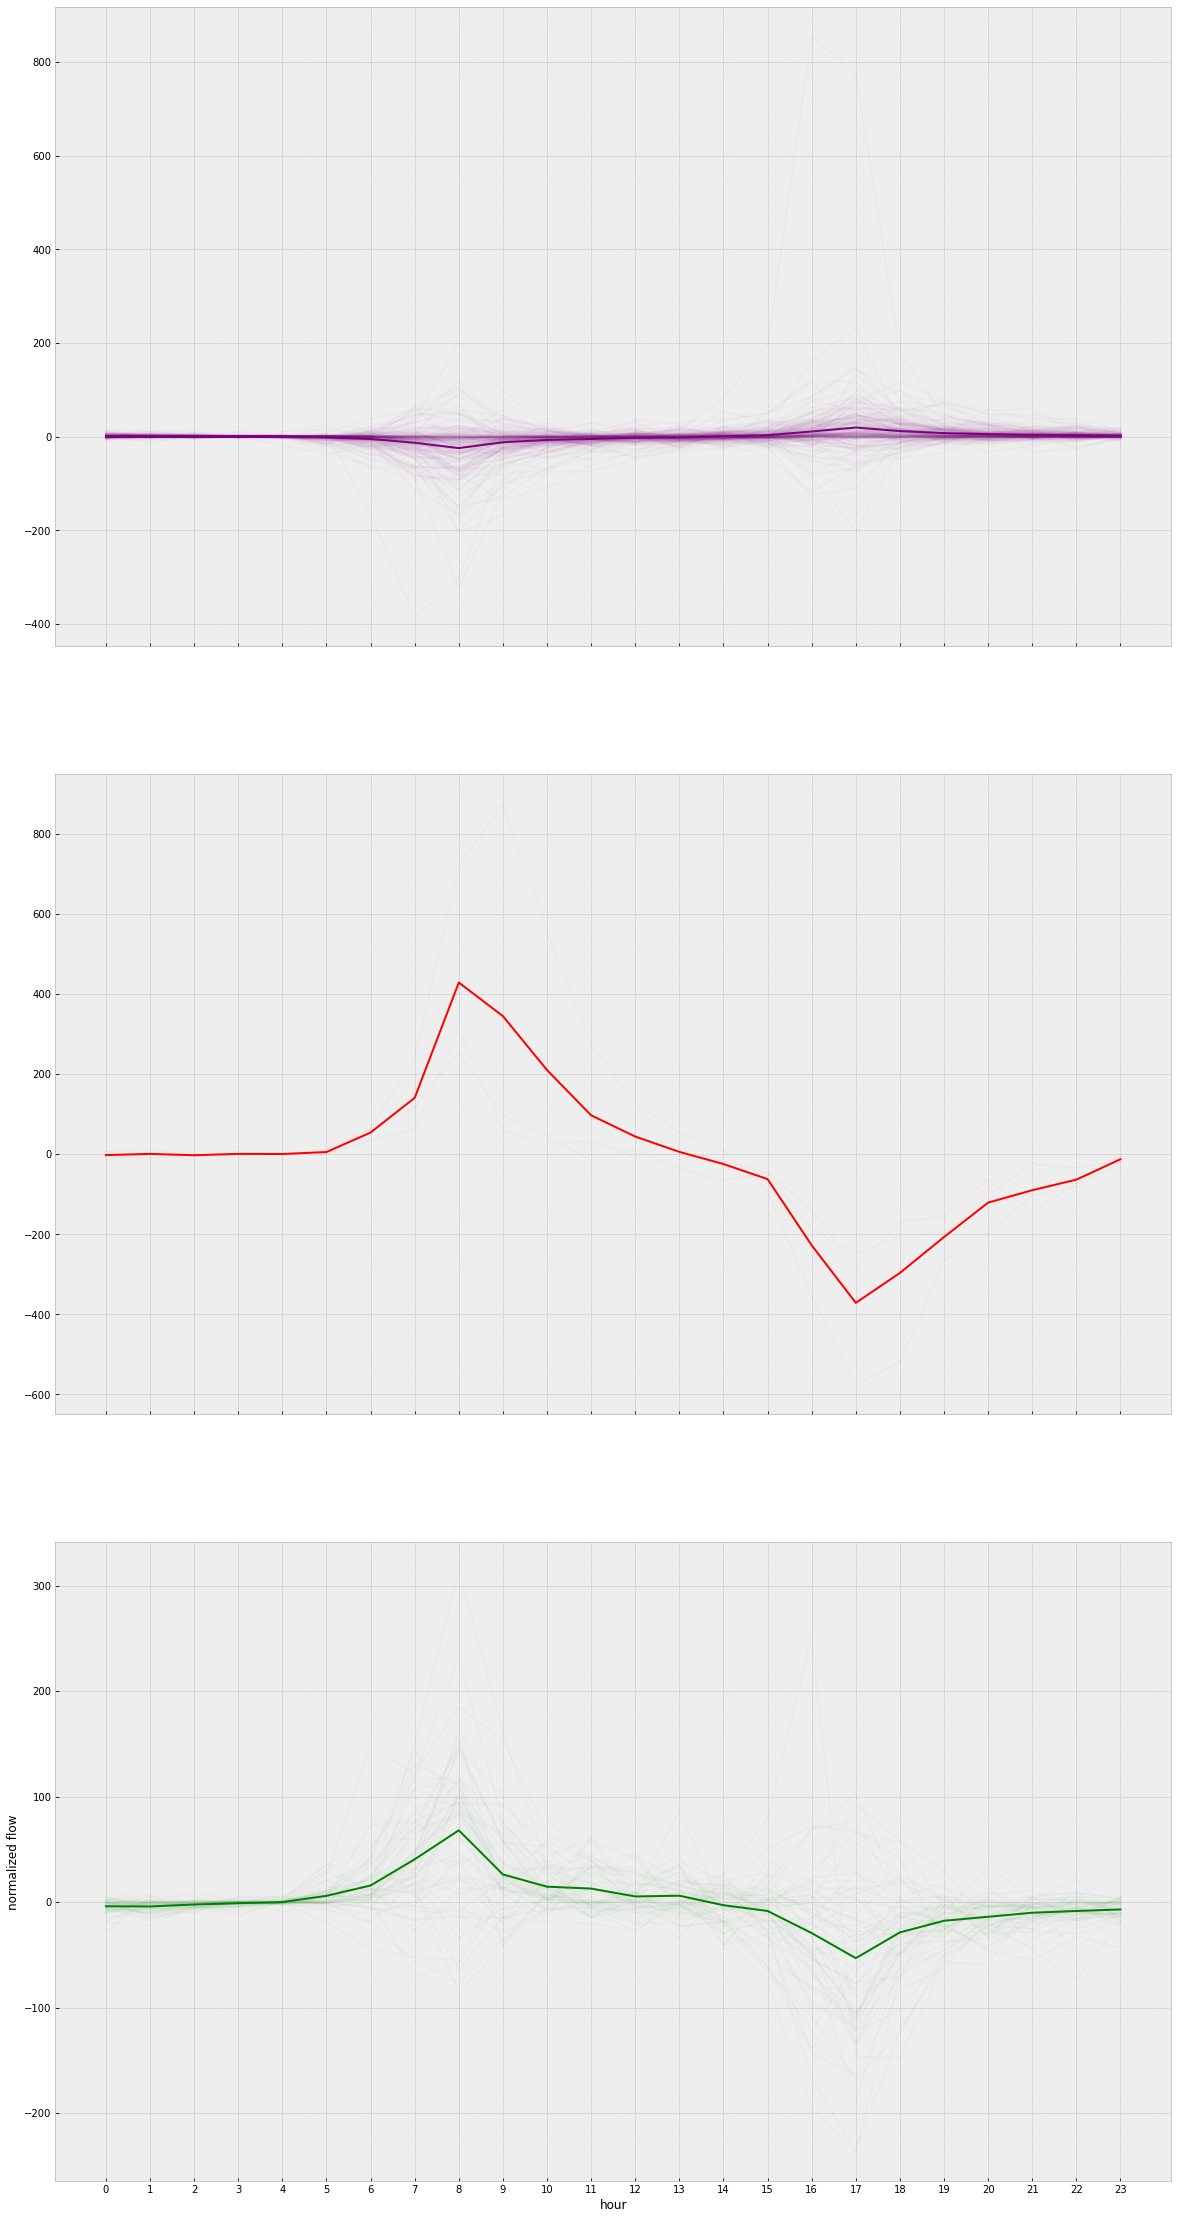

In [20]:
BOS_matrix['cluster'] = BOS_labels
plots(BOS_matrix)

In [21]:
BOS_stations[BOS_stations['cluster'] == 2]

,Nodes,degree,in degree,out degree,PageRank authority,PageRank hub,betweenness,Community,latitude,longitude,station,cluster
1,One Kendall Square at Hampshire St / Portland St,325,158,167,0.006251,0.005856,0.004771,1,42.366277,-71.091690,One Kendall Square at Hampshire St / Portland St,2
5,Tremont St at West St,323,165,158,0.006266,0.006426,0.015237,0,42.354979,-71.063348,Tremont St at West St,2
7,Boylston St at Massachusetts Ave,357,179,178,0.006792,0.006752,0.010770,0,42.347265,-71.088088,Boylston St at Massachusetts Ave,2
10,One Broadway / Kendall Sq at Main St / 3rd St,222,104,118,0.004509,0.003965,0.001373,1,42.362242,-71.083111,One Broadway / Kendall Sq at Main St / 3rd St,2
17,One Memorial Drive,232,113,119,0.004609,0.004261,0.002329,1,42.361619,-71.080436,One Memorial Drive,2
19,Boston City Hall - 28 State St,318,156,162,0.006126,0.005905,0.006615,0,42.358920,-71.057629,Boston City Hall - 28 State St,2
22,Congress St at Sleeper St,212,101,111,0.004441,0.004024,0.002337,0,42.351004,-71.049300,Congress St at Sleeper St,2
30,Silber Way,222,116,106,0.004157,0.004424,0.001964,1,42.349496,-71.100576,Silber Way,2
33,ID Building West,140,66,74,0.003097,0.002848,0.000843,0,42.344796,-71.031614,ID Building West,2
34,Boston Medical Center - E Concord St at Harris...,178,91,87,0.003581,0.003719,0.001479,0,42.336716,-71.068808,Boston Medical Center - E Concord St at Harris...,2


## Check if the labels are assigned correctly before the plotting + parse data a bit more + improve usage of k-means


## Gegographic visualizations

In [22]:
import geopandas as gpd
from shapely.geometry import Point

# from https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
ny_geo = gpd.read_file('data/ny_districts.geojson')
# from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9
chi_geo = gpd.read_file('data/chi_districts.geojson')
# from https://gist.github.com/gtallen1187/69a431091c43db10096142883c4acb5f
bos_geo = gpd.read_file('data/bos_districts.geojson')

# prendere mappe diverse

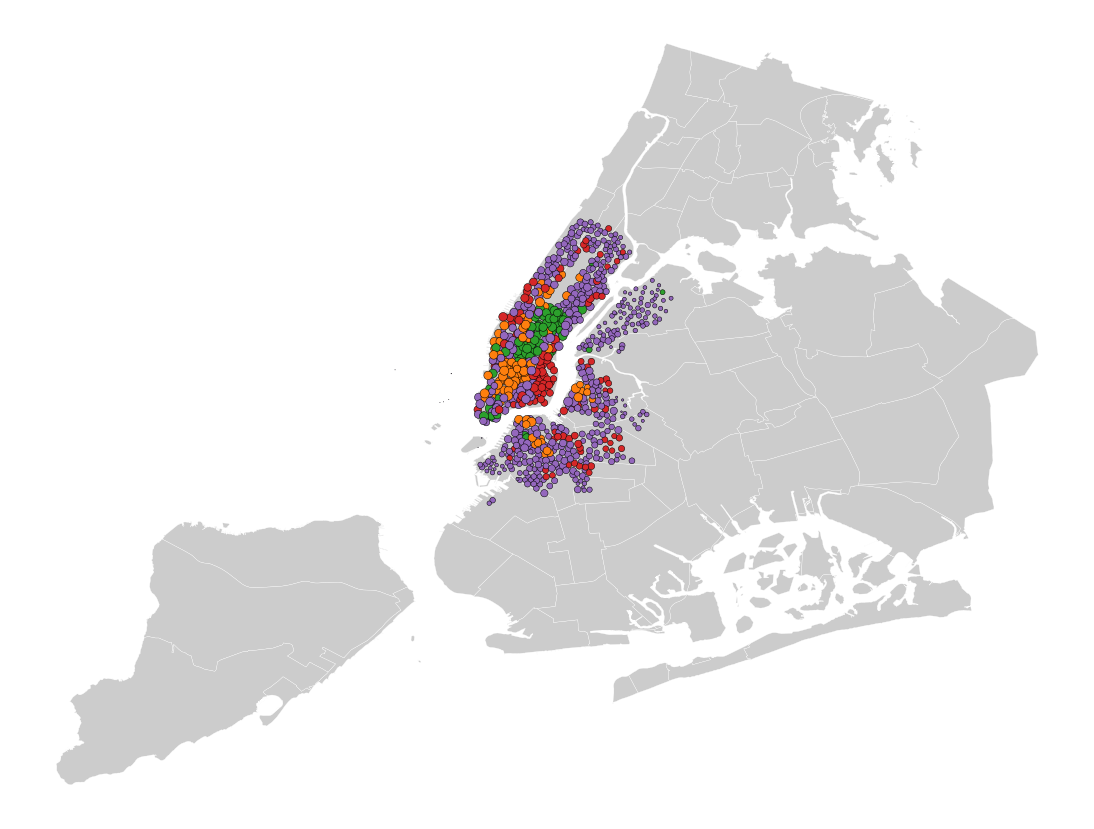

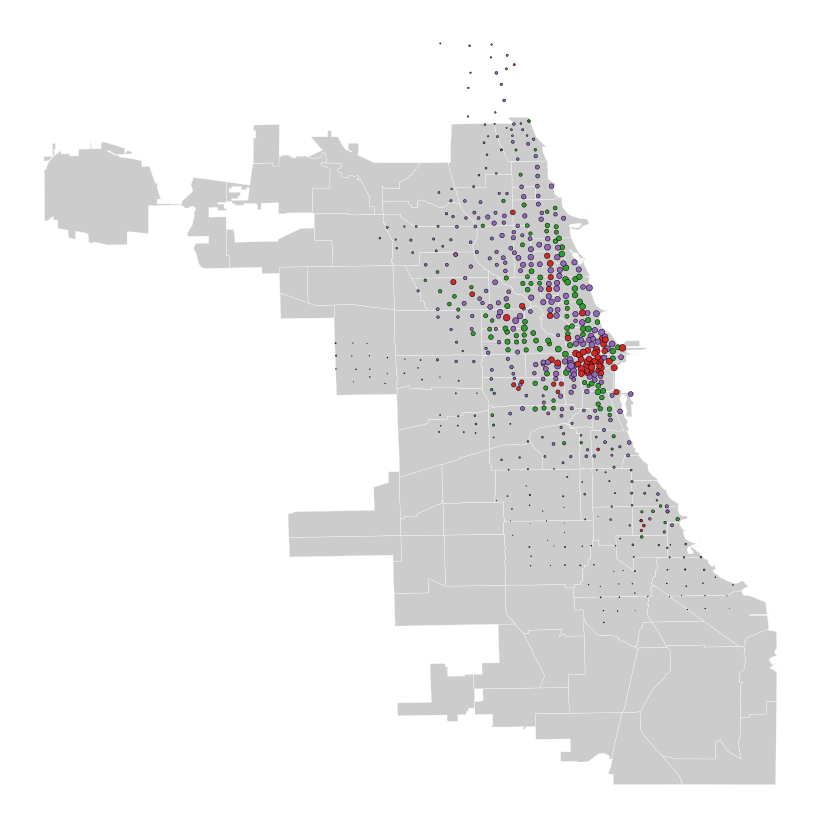

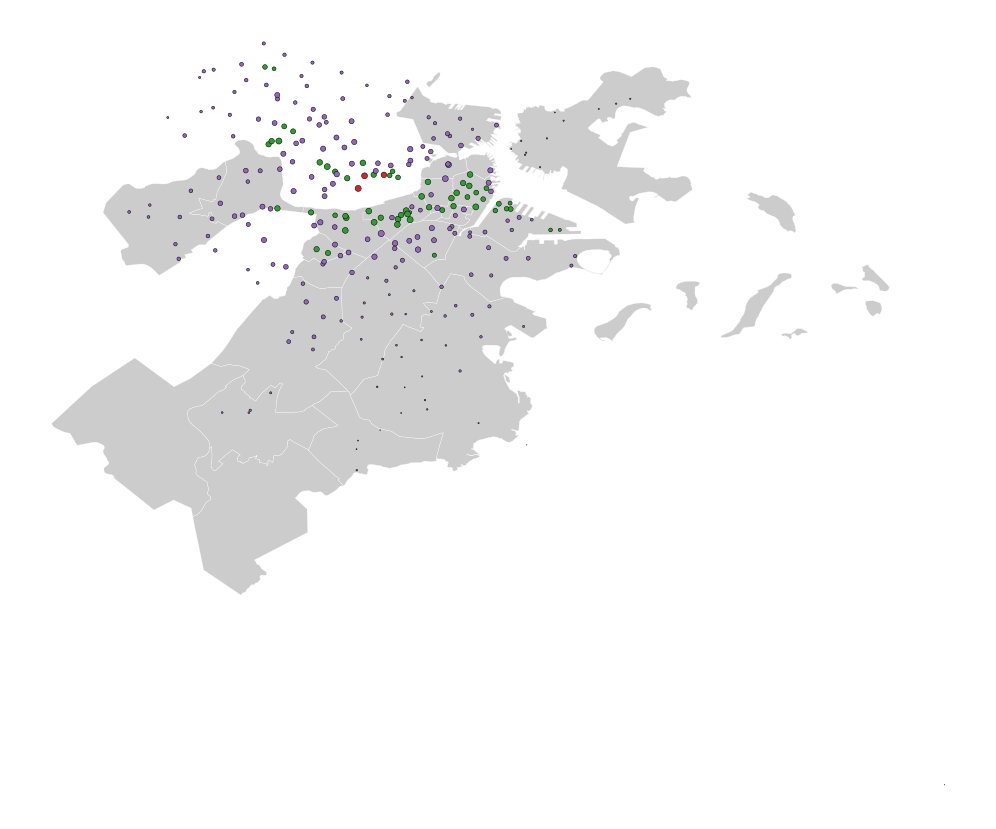

In [23]:
colors = {0:'tab:purple', 1:'tab:red', 2:'tab:green', 3:'tab:orange'}

def geo_plot(gmap, df):
    # need to create the GeoDataFrame
    geom = []
    for long, lat in zip(df['longitude'], df['latitude']):
        geom.append(Point(long, lat))
    df['geometry'] = geom
    gdf = gpd.GeoDataFrame(df, geometry = 'geometry')
    
    fig, ax = plt.subplots(figsize=(20,15))
    ax.axis('off')
    gmap.plot(ax=ax, edgecolor='white', linewidth=0.3, color='0.8')
    # gdf_copy = gdf.sort_values('degree', ascending=False).head(100)
    # gdf_copy.plot(ax=ax, markersize=gdf_copy['degree']/10, c=gdf_copy['cluster'].map(colors), edgecolor='black', linewidth=0.5)
    gdf.plot(ax=ax, markersize=gdf['degree']/10, c=gdf['cluster'].map(colors), edgecolor='black', linewidth=0.5)

    # NY_gdf_copy.to_file("results/ny_bike-st_vs_sub-st.geojson", driver='GeoJSON')

    # ax.legend(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
    
geo_plot(ny_geo, NY_stations)
geo_plot(chi_geo, CHI_stations)
geo_plot(bos_geo, BOS_stations)